# Base model and data collection

In [2]:
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import os

2022-11-29 16:34:30.792280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 16:34:31.060798: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-29 16:34:31.111799: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-29 16:34:31.111843: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data

In [5]:
os.listdir('./raw_data')


['chpn-p12.mid',
 'chpn_op25_e12.mid',
 'chpn-p11.mid',
 'chpn-p16.mid',
 'chpn_op10_e05.mid',
 'chpn-p8.mid',
 'chpn_op7_2.mid',
 'chpn_op25_e1.mid',
 'chpn-p10.mid',
 'chpn-p14.mid',
 'chpn_op23.mid',
 'chpn-p6.mid',
 'chpn-p22.mid',
 'chpn_op35_2.mid',
 'chpn-p21.mid',
 'chpn_op10_e12.mid',
 'chpn-p18.mid',
 'chpn-p7.mid',
 'chpn_op35_3.mid',
 'chpn-p17.mid',
 'chpn-p1.mid',
 'chpn-p9.mid',
 'chpn_op27_2.mid',
 'chpn-p13.mid',
 'chpn_op35_1.mid',
 'chpn_op7_1.mid',
 'chpn_op25_e4.mid',
 'chpn_op27_1.mid',
 'chpn-p15.mid',
 'chpn-p4.mid',
 'chpn-p23.mid',
 'chpn_op35_4.mid',
 'chpn-p24.mid',
 'chpn_op25_e3.mid',
 'chp_op31.mid',
 'chopin.zip',
 'chpn_op25_e2.mid',
 'chpn_op66.mid',
 'chpn-p2.mid',
 'chp_op18.mid',
 'chpn-p5.mid',
 'chpn_op33_4.mid',
 'chpn_op10_e01.mid',
 'chpn_op53.mid',
 'chpn-p19.mid',
 'chpn-p20.mid',
 'chpn-p3.mid',
 'chpn_op33_2.mid',
 'chpn_op25_e11.mid']

In [3]:
#Loading the list of chopin's midi files as stream 
#filepath = os.path.join("code", "Kulle77", "Karlobyo", "composer_electronifire", "raw_data")
#Getting midi files
filepath = './raw_data'
all_midis= []
for i in os.listdir('./raw_data'):
    if i.endswith(".mid"):
        tr = os.path.join(filepath, i)
        midi = converter.parse(tr)
        all_midis.append(midi)

/home/bob/.pyenv/versions/3.10.6/envs/composer_electronifire/lib/python3.10/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2002 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/home/bob/.pyenv/versions/3.10.6/envs/composer_electronifire/lib/python3.10/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2003 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/home/bob/.pyenv/versions/3.10.6/envs/composer_electronifire/lib/python3.10/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1997 by Bernd Krueger'>; getting generic Instrument
  warnings.warn

KeyError: 140444798522016

In [4]:
#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 13478


In [38]:
Corpus[:10]


['11.3.4', '3.8', '11.4', '8', 'F4', '11.3.5', '3', 'F#4', '11.3.6', '3.8']

##Data exploration

In [5]:
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 265


In [6]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrence for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrence for a note in Corpus: 50.86037735849057
Most frequent note in Corpus appeared: 350 times
Least frequent note in Corpus appeared: 1 time


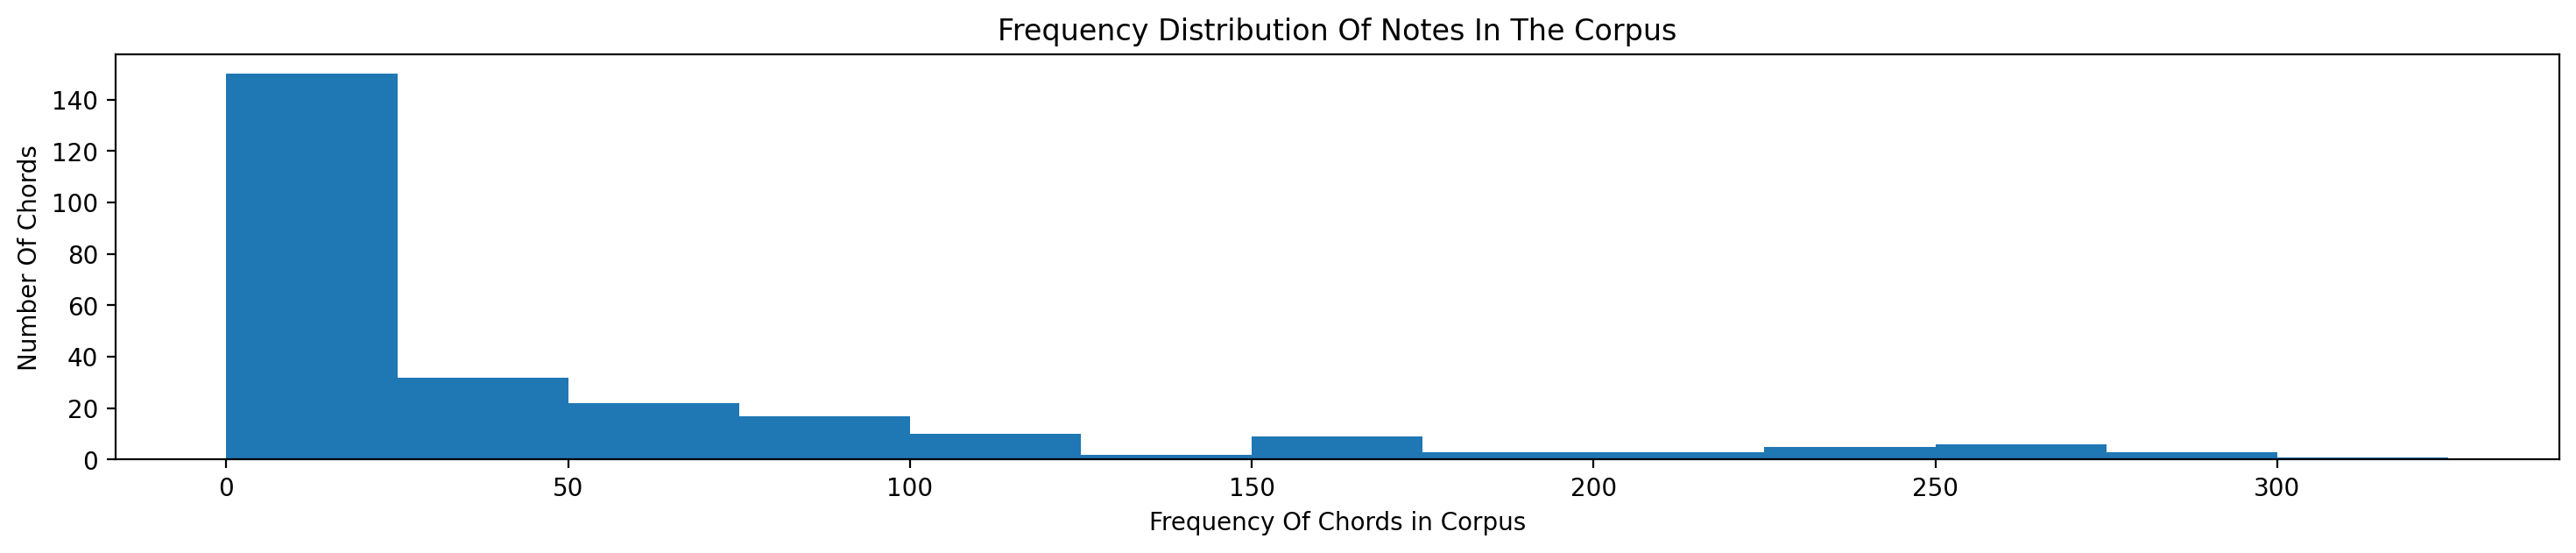

In [7]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3))
bins = np.arange(0,(max(Recurrence)), 25) 
plt.hist(Recurrence, bins=bins)
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [8]:
#Getting a list of rare chords
rare_notes = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        rare_notes.append(key)
        
print("Total number of notes that occur less than 100 times:", len(rare_notes))

Total number of notes that occur less than 100 times: 221


In [38]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_notes:
        Corpus.remove(element)

print("Length of Corpus after elemination of the rare notes:", len(Corpus))

Length of Corpus after elemination of the rare notes: 59426


## Preprocessing

In [9]:
# functions
def note_transformer(note_list, seq_length=40):
  """Function which takes a list of musical notes, 
  and returns numpy arrays of X and y where X contains 
  encoded sequences of these notes, and y corresponds 
  to the seq_length following notes of that sequence"""

  symb = sorted(list(set(note_list)))

  mapping = dict((c, i) for i, c in enumerate(symb))
  reverse_mapping = dict((i, c) for i, c in enumerate(symb))

  length = seq_length
  features = []
  targets = []
  for i in range(0, len(note_list) - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
  
  X = (np.reshape(features, (len(targets), length, 1)))/ float(len(symb))
  y = tensorflow.keras.utils.to_categorical(targets) 

  return X, y
  

In [10]:
X, y = note_transformer(Corpus)

In [11]:
X.shape

(13438, 40, 1)

In [15]:
rs_X = X.reshape(13438, 40)

In [16]:
rs_X[0,:]

array([0.21886792, 0.37735849, 0.23018868, 0.59245283, 0.93962264,
       0.22264151, 0.29811321, 0.91698113, 0.22641509, 0.37735849,
       0.98867925, 0.36603774, 0.59245283, 0.96603774, 0.64150943,
       0.29811321, 0.72830189, 0.38490566, 0.64150943, 0.7509434 ,
       0.16603774, 0.59245283, 0.77358491, 0.64150943, 0.29811321,
       0.81886792, 0.6       , 0.64150943, 0.79622642, 0.0754717 ,
       0.59245283, 0.84150943, 0.24150943, 0.29811321, 0.86792453,
       0.16603774, 0.16603774, 0.89433962, 0.39245283, 0.35849057])

In [17]:
X[0,:,:]

array([[0.21886792],
       [0.37735849],
       [0.23018868],
       [0.59245283],
       [0.93962264],
       [0.22264151],
       [0.29811321],
       [0.91698113],
       [0.22641509],
       [0.37735849],
       [0.98867925],
       [0.36603774],
       [0.59245283],
       [0.96603774],
       [0.64150943],
       [0.29811321],
       [0.72830189],
       [0.38490566],
       [0.64150943],
       [0.7509434 ],
       [0.16603774],
       [0.59245283],
       [0.77358491],
       [0.64150943],
       [0.29811321],
       [0.81886792],
       [0.6       ],
       [0.64150943],
       [0.79622642],
       [0.0754717 ],
       [0.59245283],
       [0.84150943],
       [0.24150943],
       [0.29811321],
       [0.86792453],
       [0.16603774],
       [0.16603774],
       [0.89433962],
       [0.39245283],
       [0.35849057]])

In [19]:
X_df = pd.DataFrame(rs_X)
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.218868,0.377358,0.230189,0.592453,0.939623,0.222642,0.298113,0.916981,0.226415,0.377358,...,0.592453,0.841509,0.241509,0.298113,0.867925,0.166038,0.166038,0.894340,0.392453,0.358491
1,0.377358,0.230189,0.592453,0.939623,0.222642,0.298113,0.916981,0.226415,0.377358,0.988679,...,0.841509,0.241509,0.298113,0.867925,0.166038,0.166038,0.894340,0.392453,0.358491,0.867925
2,0.230189,0.592453,0.939623,0.222642,0.298113,0.916981,0.226415,0.377358,0.988679,0.366038,...,0.241509,0.298113,0.867925,0.166038,0.166038,0.894340,0.392453,0.358491,0.867925,0.166038
3,0.592453,0.939623,0.222642,0.298113,0.916981,0.226415,0.377358,0.988679,0.366038,0.592453,...,0.298113,0.867925,0.166038,0.166038,0.894340,0.392453,0.358491,0.867925,0.166038,0.166038
4,0.939623,0.222642,0.298113,0.916981,0.226415,0.377358,0.988679,0.366038,0.592453,0.966038,...,0.867925,0.166038,0.166038,0.894340,0.392453,0.358491,0.867925,0.166038,0.166038,0.796226


In [22]:
X_df.to_csv('./preprocessed_data/X.csv')

In [24]:
y.shape

(13438, 265)

In [27]:
pd.DataFrame(y).to_csv('./preprocessed_data/y.csv')

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Creating the model

In [56]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics='accuracy')

In [57]:
es = EarlyStopping(patience=50, restore_best_weights=True)

In [58]:
history = model.fit(X_train[:5000], y_train[:5000], 
                    batch_size=16, epochs=1000, 
                    verbose=2, callbacks=es, 
                    validation_split=0.2)

Epoch 1/1000
250/250 - 8s - loss: 4.7144 - accuracy: 0.0247 - val_loss: 4.4761 - val_accuracy: 0.0350 - 8s/epoch - 31ms/step
Epoch 2/1000
250/250 - 3s - loss: 4.4450 - accuracy: 0.0262 - val_loss: 4.3751 - val_accuracy: 0.0310 - 3s/epoch - 12ms/step
Epoch 3/1000
250/250 - 3s - loss: 4.4163 - accuracy: 0.0300 - val_loss: 4.3508 - val_accuracy: 0.0330 - 3s/epoch - 12ms/step
Epoch 4/1000
250/250 - 3s - loss: 4.4113 - accuracy: 0.0310 - val_loss: 4.3575 - val_accuracy: 0.0330 - 3s/epoch - 12ms/step
Epoch 5/1000
250/250 - 3s - loss: 4.4077 - accuracy: 0.0338 - val_loss: 4.3983 - val_accuracy: 0.0330 - 3s/epoch - 12ms/step
Epoch 6/1000
250/250 - 3s - loss: 4.4001 - accuracy: 0.0280 - val_loss: 4.3913 - val_accuracy: 0.0300 - 3s/epoch - 12ms/step
Epoch 7/1000
250/250 - 3s - loss: 4.3993 - accuracy: 0.0325 - val_loss: 4.3848 - val_accuracy: 0.0300 - 3s/epoch - 12ms/step
Epoch 8/1000
250/250 - 3s - loss: 4.4004 - accuracy: 0.0345 - val_loss: 4.4098 - val_accuracy: 0.0290 - 3s/epoch - 12ms/step
